In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from string import ascii_letters
import seaborn as sns
import json 
from scipy.spatial.transform import Rotation as R


# need to calculate visible size --> ground plane as real world size 
# depth of target - average depth of target object (thats another regressor)
# - overestimation when average depth is bigger, and under when smaller 

In [2]:
pdir = '/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_data/'

TAC_250 = pd.read_csv(pdir + 'raw_250_data.csv')
TAC_500 = pd.read_csv(pdir + 'raw_500_data.csv')
TAC_750 = pd.read_csv(pdir + 'raw_750_data.csv')
TAC_1000 = pd.read_csv(pdir + 'raw_1000_data.csv')

In [3]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    - trial RT 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        trial_RT = pd.pivot_table(duration, values = ["trial_RT"], columns = ["stimulus"], aggfunc = np.mean)
        trial_RT.reset_index()
        trial_RT_renamed = trial_RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, trial_RT_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [4]:
TAC_raw_trial_pivot = trial_pivotTable([TAC_250, TAC_500, TAC_750, TAC_1000])


In [5]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        rts = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)  
            
            trial_RT = row['Average Trial RT']
            rts.append(trial_RT)
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        RTs.append(rts)

    return xs, ys, stes, actualdepths, stds, RTs

In [6]:
TAC_trial_raw_final = trial_getxy(TAC_raw_trial_pivot)


In [7]:
TAC_trial_plot_data = TAC_trial_raw_final

## Execute this cell to prep for plotting
TAC_final_x_250 = TAC_trial_plot_data[0][0]
TAC_final_y_250 = TAC_trial_plot_data[1][0]
TAC_ste_250 = TAC_trial_plot_data[2][0]
TAC_stim_250 = TAC_trial_plot_data[3][0]
TAC_std_250 = TAC_trial_plot_data[4][0]
TAC_RT_250 = TAC_trial_plot_data[5][0]
TAC_stimfolder_250 = [elem.split('/')[1][:-2] for elem in TAC_final_x_250]


TAC_final_x_500 = TAC_trial_plot_data[0][1]
TAC_final_y_500 = TAC_trial_plot_data[1][1]
TAC_ste_500 = TAC_trial_plot_data[2][1]
TAC_stim_500 = TAC_trial_plot_data[3][1]
TAC_std_500 = TAC_trial_plot_data[4][1]
TAC_RT_500 = TAC_trial_plot_data[5][1]
TAC_stimfolder_500 = [elem.split('/')[1][:-2] for elem in TAC_final_x_500]



TAC_final_x_750 = TAC_trial_plot_data[0][2]
TAC_final_y_750 = TAC_trial_plot_data[1][2]
TAC_ste_750 = TAC_trial_plot_data[2][2]
TAC_stim_750 = TAC_trial_plot_data[3][2]
TAC_std_750 = TAC_trial_plot_data[4][2]
TAC_RT_750 = TAC_trial_plot_data[5][2]
TAC_stimfolder_750 = [elem.split('/')[1][:-2] for elem in TAC_final_x_750]


TAC_final_x_1000 = TAC_trial_plot_data[0][3]
TAC_final_y_1000 = TAC_trial_plot_data[1][3]
TAC_ste_1000 = TAC_trial_plot_data[2][3]
TAC_stim_1000 = TAC_trial_plot_data[3][3]
TAC_std_1000 = TAC_trial_plot_data[4][3]
TAC_RT_1000 = TAC_trial_plot_data[5][3]
TAC_stimfolder_1000 = [elem.split('/')[1][:-2] for elem in TAC_final_x_1000]


In [8]:
residuals_250 = np.load('/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_250.npy')
residuals_500 = np.load('/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_500.npy')
residuals_750 = np.load('/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_750.npy')
residuals_1000 = np.load('/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_1000.npy')



# Ground Plane

In [29]:
with open('/Users/prachi/Documents/depth_duration/SUN_scene_cue_coding/gp_metrics.json', 'r') as f:
    gp_metrics_json = json.load(f)
    
gp_metrics_json['000103_2014-05-14_22-01-17_260595134347_rgbf000152-resize']

[0.5685023382302951, 0.3198630136986301, 0.5626415094339623]

In [30]:
# extract GP metrics in the same stimulus order as the TAC data

VGP_GP = []
VGP_Full = []
GP_Full = []
for folder in TAC_stimfolder_250:
    try:
        stim_metrics = gp_metrics_json[folder]
        VGP_GP.append(stim_metrics[0])
        VGP_Full.append(stim_metrics[1])
        GP_Full.append(stim_metrics[2])
    except:
        VGP_GP.append(None)
        VGP_Full.append(None)
        GP_Full.append(None)



In [31]:
TAC_final_x_250[0]

'depth_duration_stimuli/002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2/002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2-target.png'

In [32]:
# exclude GP metric values that have None and exclude the corresponding TAC data 

final_VGP_GP = []
final_VGP_Full = [] 
final_GP_Full = []

GP_filtered_stim = []
GP_filtered_actualdepth = []
GP_filtered_y_250 = []
GP_filtered_y_500 = []
GP_filtered_y_750 = []
GP_filtered_y_1000 = []

GP_filtered_resid_250 = []
GP_filtered_resid_500 = []
GP_filtered_resid_750 = []
GP_filtered_resid_1000 = []

for i in range(len(VGP_GP)):
    if VGP_GP[i] != None:
        final_VGP_GP.append(VGP_GP[i])
        final_VGP_Full.append(VGP_Full[i])
        final_GP_Full.append(GP_Full[i])
        
        GP_filtered_stim.append(TAC_final_x_250[i])
        GP_filtered_actualdepth.append(TAC_stim_250[i])
        GP_filtered_y_250.append(TAC_final_y_250[i])
        GP_filtered_y_500.append(TAC_final_y_500[i])
        GP_filtered_y_750.append(TAC_final_y_750[i])
        GP_filtered_y_1000.append(TAC_final_y_1000[i])
        
        GP_filtered_resid_250.append(residuals_250[i])
        GP_filtered_resid_500.append(residuals_500[i])
        GP_filtered_resid_750.append(residuals_750[i])
        GP_filtered_resid_1000.append(residuals_1000[i])
        

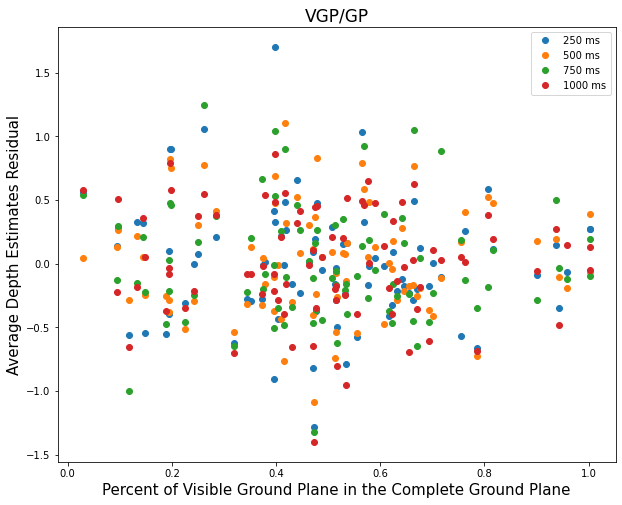

(-0.09755775714031314, 0.3773213742221838)
(-0.0015776036013107435, 0.9886366488013382)
(-0.025364505272906256, 0.8188509868568642)
(-0.0788045665222074, 0.4761286963671319)


In [33]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_resid_250), 'o', label='250 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_resid_500), 'o', label='500 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_resid_750), 'o', label='750 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_resid_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Visible Ground Plane in the Complete Ground Plane', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('VGP/GP', fontsize=17)
plt.show();

print(stats.pearsonr(final_VGP_GP, GP_filtered_resid_250))
print(stats.pearsonr(final_VGP_GP, GP_filtered_resid_500))
print(stats.pearsonr(final_VGP_GP, GP_filtered_resid_750))
print(stats.pearsonr(final_VGP_GP, GP_filtered_resid_1000))

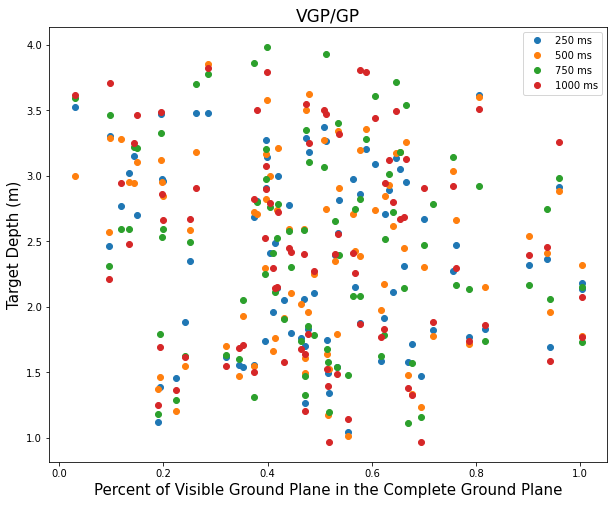

(-0.15716024020124308, 0.15337718258750507)
(-0.1153115347858275, 0.29625364790906156)
(-0.12907877974695875, 0.24191921437052538)
(-0.14447335913853385, 0.18980016549887013)


In [34]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_y_250), 'o', label='250 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_y_500), 'o', label='500 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_y_750), 'o', label='750 ms')
plt.plot(np.array(final_VGP_GP), np.array(GP_filtered_y_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Visible Ground Plane in the Complete Ground Plane', fontsize=15)
plt.ylabel('Target Depth (m)', fontsize=15)
plt.legend()
plt.title('VGP/GP', fontsize=17)
plt.show();

print(stats.pearsonr(final_VGP_GP, GP_filtered_y_250))
print(stats.pearsonr(final_VGP_GP, GP_filtered_y_500))
print(stats.pearsonr(final_VGP_GP, GP_filtered_y_750))
print(stats.pearsonr(final_VGP_GP, GP_filtered_y_1000))

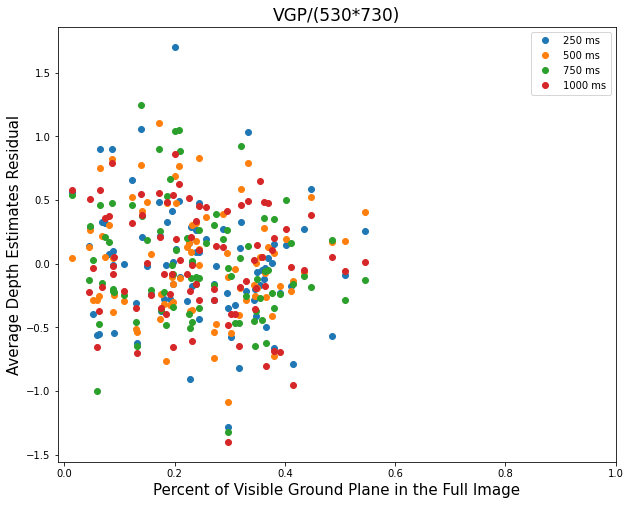

(-0.19877429934445454, 0.06988848525696467)
(-0.07537037199256966, 0.4956181344096413)
(-0.1428831110859789, 0.1947732264745129)
(-0.14691342064326515, 0.18234912747607301)


In [35]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_resid_250), 'o', label='250 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_resid_500), 'o', label='500 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_resid_750), 'o', label='750 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_resid_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Visible Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('VGP/(530*730)', fontsize=17)
plt.show();

print(stats.pearsonr(final_VGP_Full, GP_filtered_resid_250))
print(stats.pearsonr(final_VGP_Full, GP_filtered_resid_500))
print(stats.pearsonr(final_VGP_Full, GP_filtered_resid_750))
print(stats.pearsonr(final_VGP_Full, GP_filtered_resid_1000))

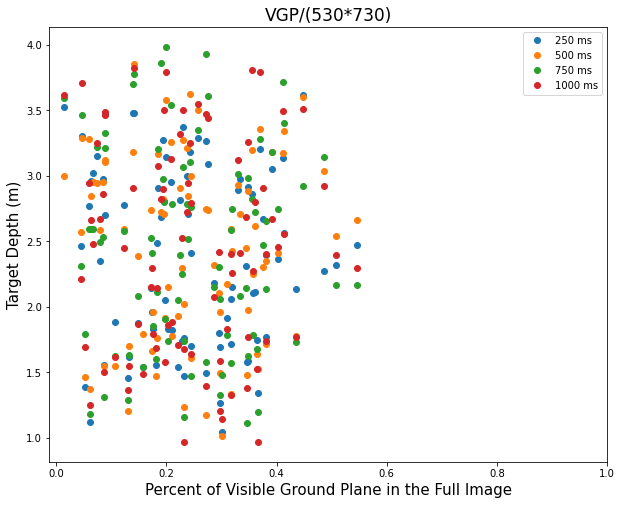

(-0.07630450405048732, 0.4902757946260915)
(-0.0010721098894948661, 0.9922775412303897)
(-0.04105228299461992, 0.7108095400037004)
(-0.035168564059712366, 0.7507930751181882)


In [36]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_y_250), 'o', label='250 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_y_500), 'o', label='500 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_y_750), 'o', label='750 ms')
plt.plot(np.array(final_VGP_Full), np.array(GP_filtered_y_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Visible Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Target Depth (m)', fontsize=15)
plt.legend()
plt.title('VGP/(530*730)', fontsize=17)
plt.show();

print(stats.pearsonr(final_VGP_Full, GP_filtered_y_250))
print(stats.pearsonr(final_VGP_Full, GP_filtered_y_500))
print(stats.pearsonr(final_VGP_Full, GP_filtered_y_750))
print(stats.pearsonr(final_VGP_Full, GP_filtered_y_1000))

In [37]:
len(GP_filtered_stim)

84

In [38]:
final_GP_Full[7]

0.24902817265443267

In [39]:
final_GP_Full.index(0.24902817265443267)

7

In [40]:
GP_filtered_stim[80]

'depth_duration_stimuli/000486_2014-06-09_20-47-20_260595134347_rgbf000143-resize_2/000486_2014-06-09_20-47-20_260595134347_rgbf000143-resize_2-target.png'

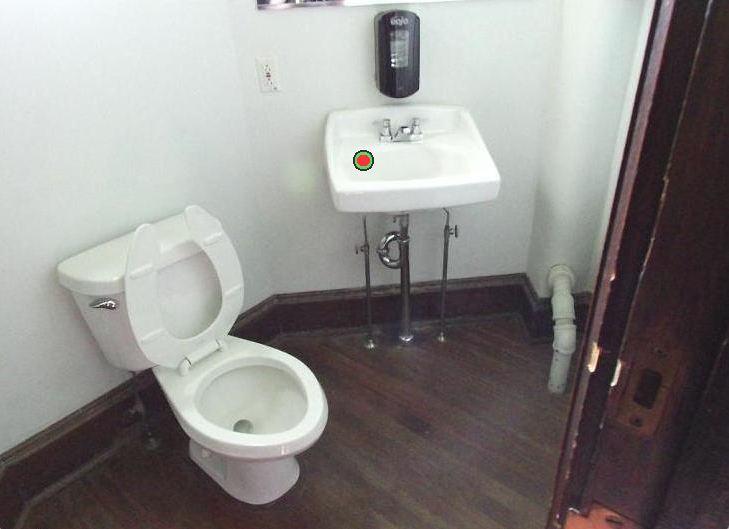

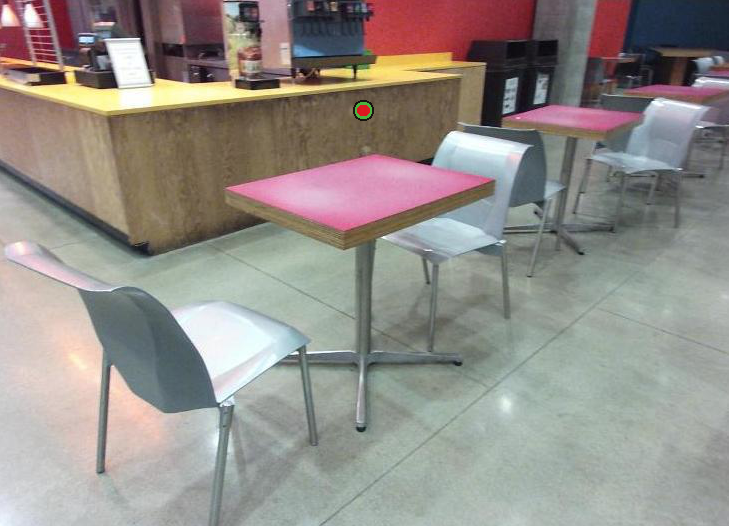

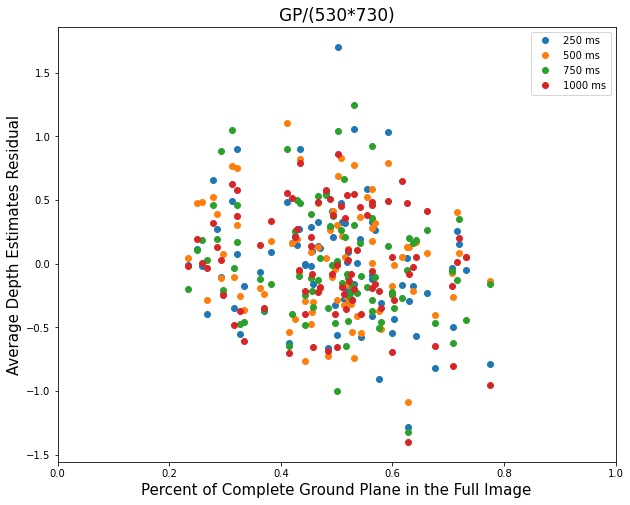

(-0.22576331139091796, 0.03893327885405739)
(-0.1514334750298652, 0.16911318834573882)
(-0.2015978126506501, 0.06592714779555248)
(-0.16467005949809574, 0.134432090713044)


In [21]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_GP_Full), np.array(GP_filtered_resid_250), 'o', label='250 ms')
plt.plot(np.array(final_GP_Full), np.array(GP_filtered_resid_500), 'o', label='500 ms')
plt.plot(np.array(final_GP_Full), np.array(GP_filtered_resid_750), 'o', label='750 ms')
plt.plot(np.array(final_GP_Full), np.array(GP_filtered_resid_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Complete Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('GP/(530*730)', fontsize=17)
plt.show();

print(stats.pearsonr(final_GP_Full, GP_filtered_resid_250))
print(stats.pearsonr(final_GP_Full, GP_filtered_resid_500))
print(stats.pearsonr(final_GP_Full, GP_filtered_resid_750))
print(stats.pearsonr(final_GP_Full, GP_filtered_resid_1000))

No handles with labels found to put in legend.


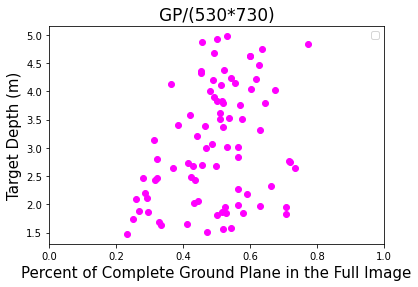

(0.3200324326396832, 0.0030007003095327838)


In [22]:
plt.figure(figsize=[6,4])

plt.plot(np.array(final_GP_Full), np.array(GP_filtered_actualdepth), 'o', color='magenta')

# plt.plot(np.array(final_GP_Full), np.array(GP_filtered_y_250), 'o', label='250 ms')
# plt.plot(np.array(final_GP_Full), np.array(GP_filtered_y_500), 'o', label='500 ms')
# plt.plot(np.array(final_GP_Full), np.array(GP_filtered_y_750), 'o', label='750 ms')
# plt.plot(np.array(final_GP_Full), np.array(GP_filtered_y_1000), 'o', label='1000 ms')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Complete Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Target Depth (m)', fontsize=15)
plt.legend()
plt.title('GP/(530*730)', fontsize=17)
plt.show();

print(stats.pearsonr(final_GP_Full, GP_filtered_actualdepth))

# print(stats.pearsonr(final_GP_Full, GP_filtered_y_250))
# print(stats.pearsonr(final_GP_Full, GP_filtered_y_500))
# print(stats.pearsonr(final_GP_Full, GP_filtered_y_750))
# print(stats.pearsonr(final_GP_Full, GP_filtered_y_1000))

#### Seperate negative and positive residuals 

In [23]:
neg_resid_250 = []
nr_GP_full_250 = []
pos_resid_250 = []
pr_GP_full_250 = []

for i in range(len(GP_filtered_resid_250)):
    if GP_filtered_resid_250[i] < 0:
        neg_resid_250.append(GP_filtered_resid_250[i])
        nr_GP_full_250.append(final_GP_Full[i])
    else:
        pos_resid_250.append(GP_filtered_resid_250[i])
        pr_GP_full_250.append(final_GP_Full[i])

In [24]:
neg_resid_1000 = []
nr_GP_full_1000 = []
pos_resid_1000 = []
pr_GP_full_1000 = []

for i in range(len(GP_filtered_resid_1000)):
    if GP_filtered_resid_1000[i] < 0:
        neg_resid_1000.append(GP_filtered_resid_1000[i])
        nr_GP_full_1000.append(final_GP_Full[i])
    else:
        pos_resid_1000.append(GP_filtered_resid_1000[i])
        pr_GP_full_1000.append(final_GP_Full[i])

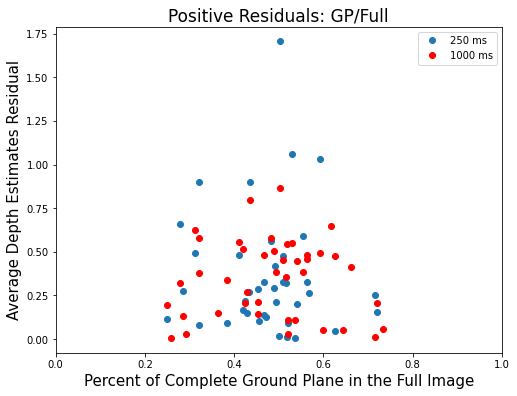

(-0.0317562554586789, 0.8478098427788341)
(-0.021207340115045825, 0.8939510463582482)


In [25]:
plt.figure(figsize=[8,6])

plt.plot(np.array(pr_GP_full_250), np.array(pos_resid_250), 'o', label='250 ms')
plt.plot(np.array(pr_GP_full_1000), np.array(pos_resid_1000), 'o', label='1000 ms', color='red')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Complete Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Positive Residuals: GP/Full', fontsize=17)
plt.show();

print(stats.pearsonr(pr_GP_full_250, pos_resid_250))
print(stats.pearsonr(pr_GP_full_1000, pos_resid_1000))

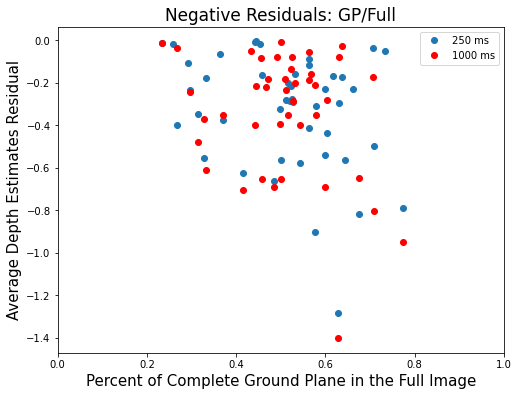

(-0.30505778912967074, 0.04158406939224184)
(-0.27406469919395243, 0.07902981146650595)


In [26]:
plt.figure(figsize=[8,6])

plt.plot(np.array(nr_GP_full_250), np.array(neg_resid_250), 'o', label='250 ms')
plt.plot(np.array(nr_GP_full_1000), np.array(neg_resid_1000), 'o', label='1000 ms', color='red')

plt.xticks(np.arange(0,1.2,0.2))
plt.xlabel('Percent of Complete Ground Plane in the Full Image', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Negative Residuals: GP/Full', fontsize=17)
plt.show();

print(stats.pearsonr(nr_GP_full_250, neg_resid_250))
print(stats.pearsonr(nr_GP_full_1000, neg_resid_1000))

### Look at all the images with % that is below 0.1





In [27]:
for i in range(len(final_GP_Full)):
    if final_GP_Full[i] < 0.1:
        print(GP_filtered_stim[i].split('/')[1])

# Extrinsics

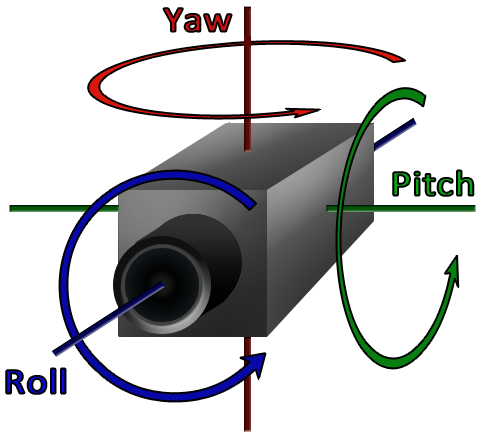

In [86]:
#converts the rotation matrix in extrinsics.txt from string to a numpy array 
def rotationmatrix(matrix_path):
    matrixtext = open(matrix_path).read()
    
    x00 = float(matrixtext.split('\t')[0].split(' ')[0])
    x01 = float(matrixtext.split('\n')[0].split(' ')[1])
    x02 = float(matrixtext.split('\n')[0].split(' ')[2])
    
    x10 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[1].split(' ')[1])
    x12 = float(matrixtext.split('\n')[1].split(' ')[2])
    
    x20 = float(matrixtext.split('\n')[2].split(' ')[0])
    x21 = float(matrixtext.split('\n')[2].split(' ')[1])
    x22 = float(matrixtext.split('\n')[2].split(' ')[2])
    
    #list of the matrix values excluding the 3rd column of just zeroes 
    matrixlist = [[x00, x01, x02], [x10, x11, x12], [x20, x21, x22]]
    
    #creates 3x3 array of the rotation matrix
    matrixarray = np.full((3,3), matrixlist)
    
    return matrixarray

def rotationMatrixToEulerAngles(path):
    R = rotationmatrix(path)
    #assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# Output - final pitch, roll, yaw values in radians and degrees 
def imageExtrinsics(path):
    in_array = rotationMatrixToEulerAngles(path)
    #print ("Radian values : \n", in_array) 

    degree_Values = np.degrees(in_array) 
    
    return degree_Values[0], degree_Values[1], degree_Values[2]


def extrinsics_distribution(path, kinectv2):
    targetfolder = path.split('/')[1]
    if len(targetfolder) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = path.split('/')[1][:-3]

    extpath = kinectv2 + '/' + imagefolder + '/extrinsics' 
    fname = os.listdir(extpath)[0]
    if fname != '.ipynb_checkpoints':
        extrinsics = imageExtrinsics(extpath + '/' + fname)
    # pitch, roll, yaw
    return extrinsics[0], extrinsics[1], extrinsics[2]

In [191]:
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

pitches = [extrinsics_distribution(path, kinectv2_path)[0] for path in TAC_final_x_250]
rolls = [extrinsics_distribution(path, kinectv2_path)[1] for path in TAC_final_x_250]
yaws = [extrinsics_distribution(path, kinectv2_path)[2] for path in TAC_final_x_250]

residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

To get p-values, remove the [0] index from the pearsonr call

In [192]:
roll_corrs = [scipy.stats.pearsonr(rolls, resid_dur)[0] for resid_dur in residuals]

pitch_corrs = [scipy.stats.pearsonr(pitches, resid_dur)[0] for resid_dur in residuals]

yaw_corrs = [scipy.stats.pearsonr(yaws, resid_dur)[0] for resid_dur in residuals]

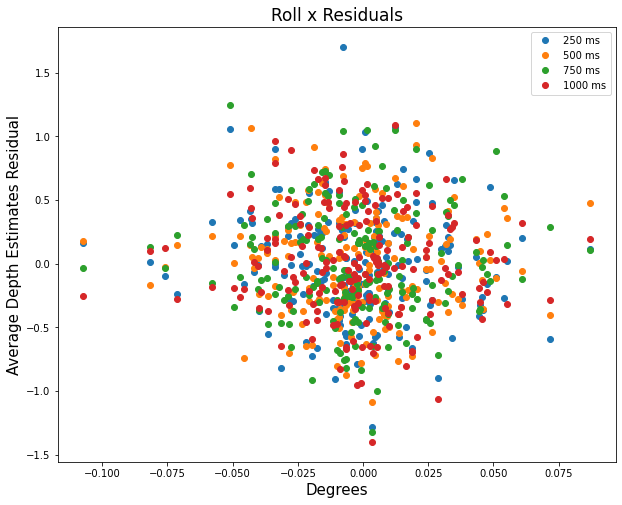

In [193]:
plt.figure(figsize=[10,8])
plt.plot(np.array(rolls), np.array(residuals[0]), 'o', label='250 ms')
plt.plot(np.array(rolls), np.array(residuals[1]), 'o', label='500 ms')
plt.plot(np.array(rolls), np.array(residuals[2]), 'o', label='750 ms')
plt.plot(np.array(rolls), np.array(residuals[3]), 'o', label='1000 ms')

plt.xlabel('Degrees', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Roll x Residuals', fontsize=17)
plt.show();

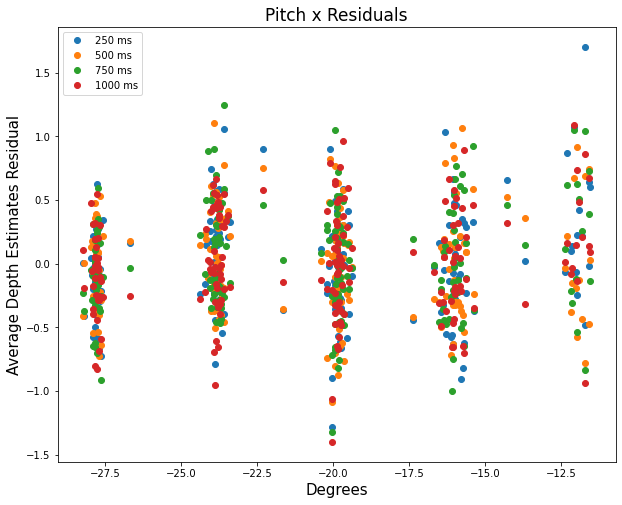

In [194]:
plt.figure(figsize=[10,8])
plt.plot(np.array(pitches), np.array(residuals[0]), 'o', label='250 ms')
plt.plot(np.array(pitches), np.array(residuals[1]), 'o', label='500 ms')
plt.plot(np.array(pitches), np.array(residuals[2]), 'o', label='750 ms')
plt.plot(np.array(pitches), np.array(residuals[3]), 'o', label='1000 ms')

plt.xlabel('Degrees', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Pitch x Residuals', fontsize=17)
plt.show();

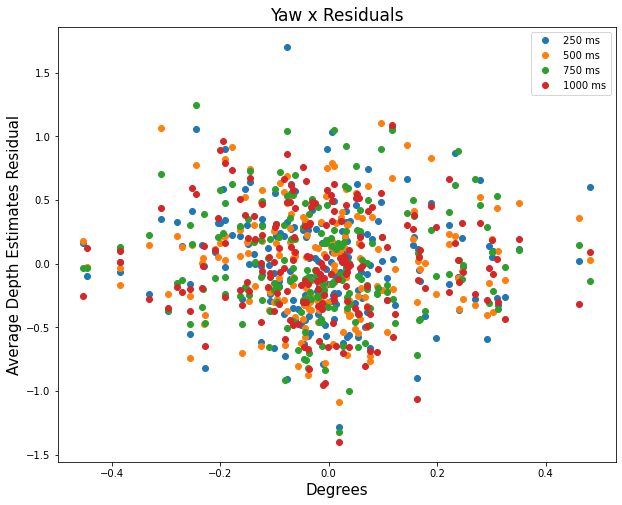

In [195]:
plt.figure(figsize=[10,8])
plt.plot(np.array(yaws), np.array(residuals[0]), 'o', label='250 ms')
plt.plot(np.array(yaws), np.array(residuals[1]), 'o', label='500 ms')
plt.plot(np.array(yaws), np.array(residuals[2]), 'o', label='750 ms')
plt.plot(np.array(yaws), np.array(residuals[3]), 'o', label='1000 ms')

plt.xlabel('Degrees', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Yaw x Residuals', fontsize=17)
plt.show();

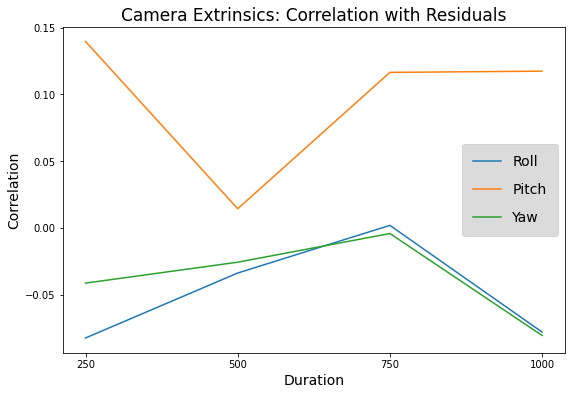

In [196]:
plt.figure(figsize = [9, 6])
plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, roll_corrs, label = 'Roll')
plt.plot(durations, pitch_corrs, label = 'Pitch')
plt.plot(durations, yaw_corrs, label = 'Yaw')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

### Is pitch correlated with GP Metrics?

In [197]:
GP_filtered_pitches = []
GP_filtered_rolls = []
GP_filtered_yaws = []

for i in range(len(VGP_GP)):
    if VGP_GP[i] != None:
        GP_filtered_pitches.append(pitches[i])
        GP_filtered_rolls.append(rolls[i])
        GP_filtered_yaws.append(yaws[i])


In [142]:
np.max(np.array(GP_filtered_rolls))

-11.581410515407137

In [144]:
GP_filtered_rolls.index(-11.581410515407137)

73

In [147]:
GP_filtered_stim[73]

'depth_duration_stimuli/002414_2014-06-28_20-24-58_260595134347_rgbf000067-resize_4/002414_2014-06-28_20-24-58_260595134347_rgbf000067-resize_4-target.png'

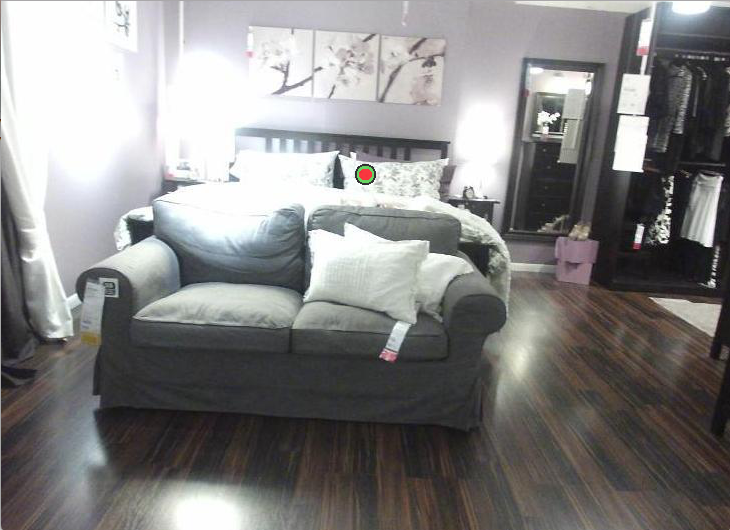

In [145]:
np.min(np.array(GP_filtered_rolls))

-28.21927558408976

In [146]:
GP_filtered_rolls.index(-28.21927558408976)

54

In [148]:
GP_filtered_stim[54]

'depth_duration_stimuli/001584_2014-06-20_11-07-43_260595134347_rgbf000002-resize_1/001584_2014-06-20_11-07-43_260595134347_rgbf000002-resize_1-target.png'

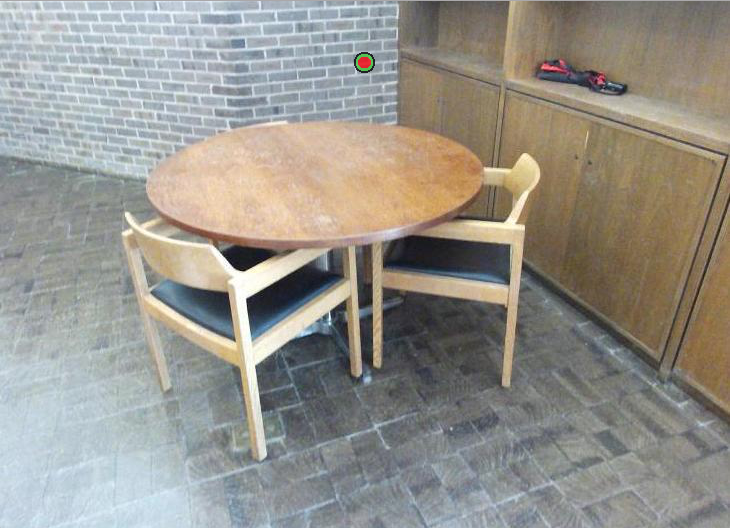

(-0.13618985257271915, 0.21673283816651906)


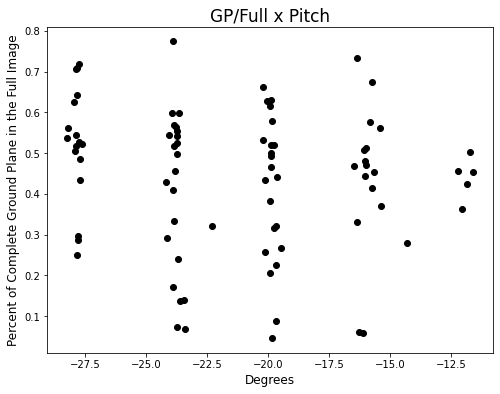

In [198]:
print(stats.pearsonr(GP_filtered_pitches, final_GP_Full))

plt.figure(figsize=[8,6])
plt.plot(np.array(GP_filtered_pitches), np.array(final_GP_Full), 'o', color='black')
plt.xlabel('Degrees', fontsize=12)
plt.ylabel('Percent of Complete Ground Plane in the Full Image', fontsize=12)
plt.title('GP/Full x Pitch', fontsize=17)
plt.show();